# Import Libraries

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from __future__ import print_function
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [19]:
def display(img, title=''):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Image Processing

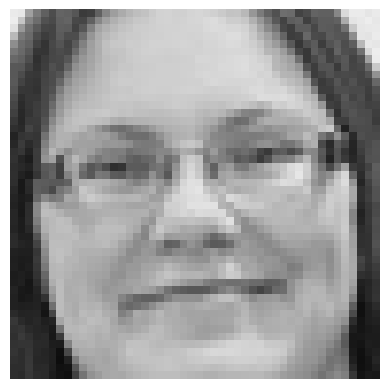

In [20]:
img = cv2.imread(r'C:\Users\PC\Downloads\Detai_TGMT_1\archive\train\happy\Training_1206.jpg')
display(img)

In [21]:
img.shape

(48, 48, 3)

In [22]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [23]:
gaussian_blur = cv2.GaussianBlur(img, (3, 3), 0)

median_blur = cv2.medianBlur(img, 5)

average_blur = cv2.blur(img, (5, 5))

laplacian = cv2.Laplacian(img, cv2.CV_64F)
laplacian_img = cv2.convertScaleAbs(laplacian)

canny = cv2.Canny(img, 50, 150)

# Unsharp mask
unsharp_mask = cv2.addWeighted(img, 1.5, gaussian_blur, -0,5, 0)

bilateral_filter = cv2.bilateralFilter(img, 9, 75, 75)

denoised_img = cv2.fastNlMeansDenoising(img, h=15, templateWindowSize=7, searchWindowSize=21)

equalized_hist = cv2.equalizeHist(img)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(img)

denoised_hist = cv2.equalizeHist(denoised_img)
hist_denoised = cv2.fastNlMeansDenoising(equalized_hist, h=15, templateWindowSize=7, searchWindowSize=21)
denoised_clahe = clahe.apply(denoised_img)
hist_clahe_denoised = clahe.apply(equalized_hist)
hist_clahe_denoised = cv2.fastNlMeansDenoising(hist_clahe_denoised, h=15, templateWindowSize=7, searchWindowSize=21)

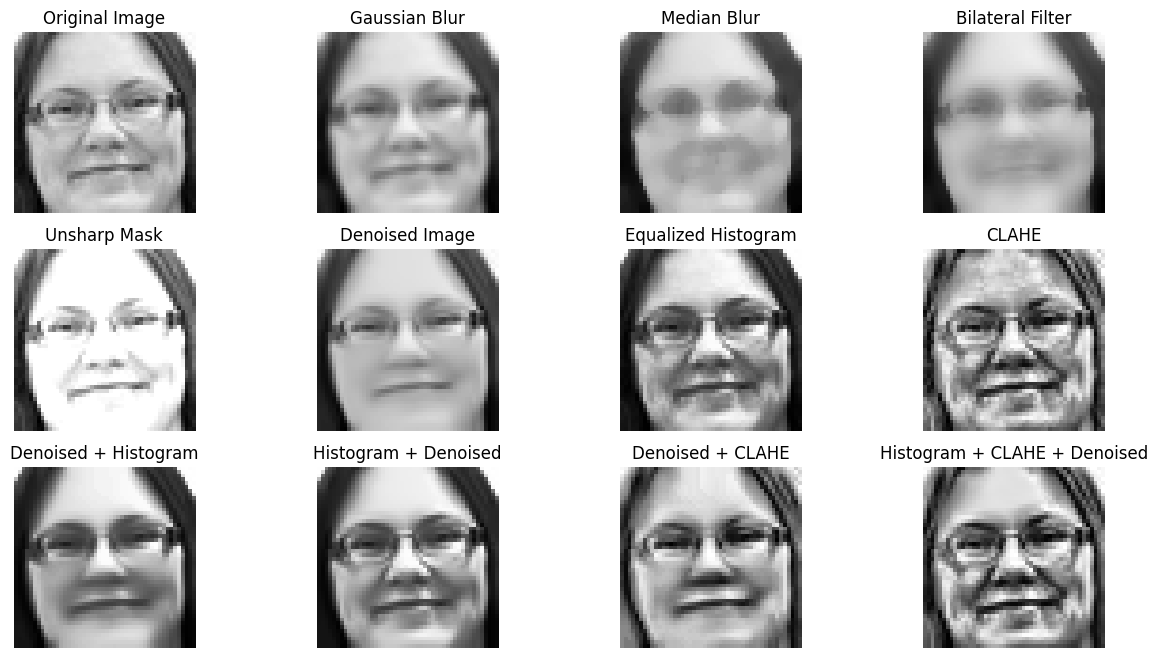

In [24]:
images = [
    img,
    gaussian_blur, 
    median_blur,
    bilateral_filter, 
    unsharp_mask,
    denoised_img, 
    equalized_hist, 
    clahe_img, 
    denoised_hist, 
    hist_denoised,
    denoised_clahe,
    hist_clahe_denoised
    ]
titles = [
    'Original Image',
    'Gaussian Blur', 
    'Median Blur',
    'Bilateral Filter', 
    'Unsharp Mask',
    'Denoised Image', 
    'Equalized Histogram', 
    'CLAHE', 
    'Denoised + Histogram', 
    'Histogram + Denoised',
    'Denoised + CLAHE',
    'Histogram + CLAHE + Denoised'
    ]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

In [25]:
IMG_SIZE = 48

In [26]:
def preprocess_image(image_path):
    # load the image
    if not os.path.exists(image_path):
        return None
    if not os.path.isfile(image_path):
        return None
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        return None
    
    img = cv2.imread(image_path)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hist_eq = cv2.equalizeHist(img_gray)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(hist_eq)

    denoised_face = cv2.fastNlMeansDenoising(clahe_img, h=15, templateWindowSize=7, searchWindowSize=21)

    resized_img = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))

    norm_img = resized_img.astype('float32') / 255.0

    return norm_img

# Prepare Data

In [27]:
train_data_path = 'C:/Users/PC/Downloads/Detai_TGMT_1/archive/train/'
test_data_path = 'C:/Users/PC/Downloads/Detai_TGMT_1/archive/test/'

In [28]:
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprise']

label_map = {emotion: idx for idx, emotion in enumerate(emotion_labels)}
label_map

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'sad': 4,
 'neutral': 5,
 'surprise': 6}

In [29]:
def load_images(data_dir):
    image_paths = []
    labels = []

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path) and label in emotion_labels: 
            for file in os.listdir(label_path):
                if file.lower().endswith('.jpg'):
                    image_path = os.path.join(label_path, file)
                    image_paths.append(image_path)
                    labels.append(label)
                    
    # Shuffle the data and labels together
    image_paths, labels = shuffle(image_paths, labels, random_state=40)
    return image_paths, labels

In [30]:
# Load and shuffle train and validation
X_train_raw, y_train_raw = load_images(train_data_path)

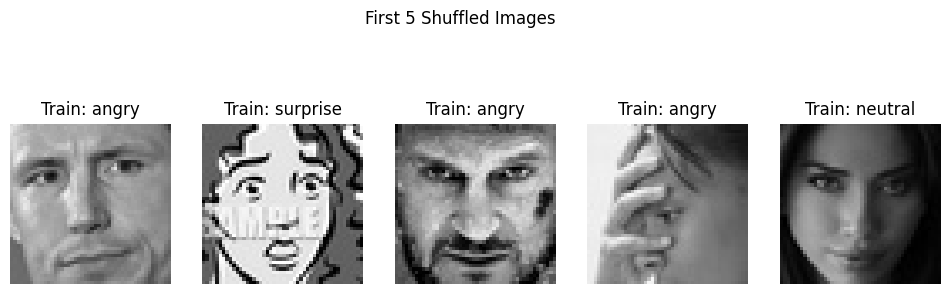

In [31]:
# Show first 5 from train
plt.figure(figsize=(12, 4))
for i in range(5):
    img = cv2.imread(X_train_raw[i], cv2.IMREAD_GRAYSCALE)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else np.zeros((48, 48))  
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Train: {y_train_raw[i]}")
    plt.axis('off')
plt.suptitle("First 5 Shuffled Images")
plt.show()

In [32]:
def process_file(emotion, file_path):
    processed_image = preprocess_image(file_path)
    if processed_image is not None:
        return processed_image, label_map[emotion]
    return None

### Prepare Train Data

In [33]:
X_train = []
y_train = []

In [34]:
for emotion in emotion_labels:
    folder_path = os.path.join(train_data_path, emotion)
    files = os.listdir(folder_path)

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(process_file, emotion, os.path.join(folder_path, f)): f for f in files}

        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {emotion}", unit="img"):
            result = future.result()
            if result is not None:
                processed_image, label = result
                X_train.append(processed_image)
                y_train.append(label)

Processing surprise: 100%|██████████| 3171/3171 [00:10<00:00, 294.10img/s]


In [35]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_cat_train = to_categorical(y_train, num_classes=len(emotion_labels))

print(f'Loaded {len(X_train)} images successfully.')

Loaded 28709 images successfully.


### Prepare Test Data

In [36]:
X_test = []
y_test = []

In [37]:
for emotion in emotion_labels:
    folder_path = os.path.join(test_data_path, emotion)
    files = os.listdir(folder_path)

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(process_file, emotion, os.path.join(folder_path, f)): f for f in files}

        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {emotion}", unit="img"):
            result = future.result()
            if result is not None:
                processed_image, label = result
                X_test.append(processed_image)
                y_test.append(label)

Processing surprise: 100%|██████████| 831/831 [00:04<00:00, 184.90img/s]


In [38]:
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_cat_test = to_categorical(y_test, num_classes=len(emotion_labels))

print(f'Loaded {len(X_test)} images successfully.')

Loaded 7178 images successfully.


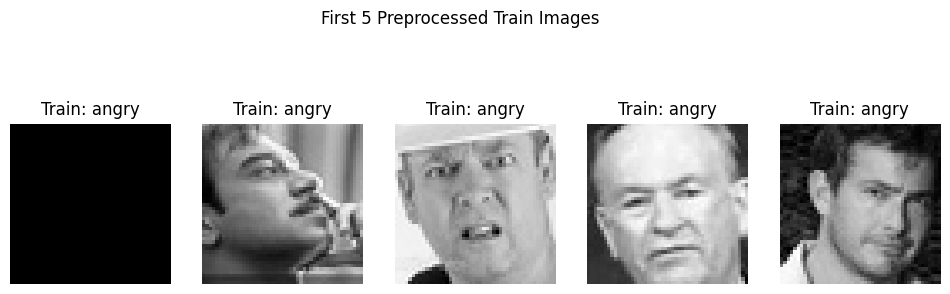

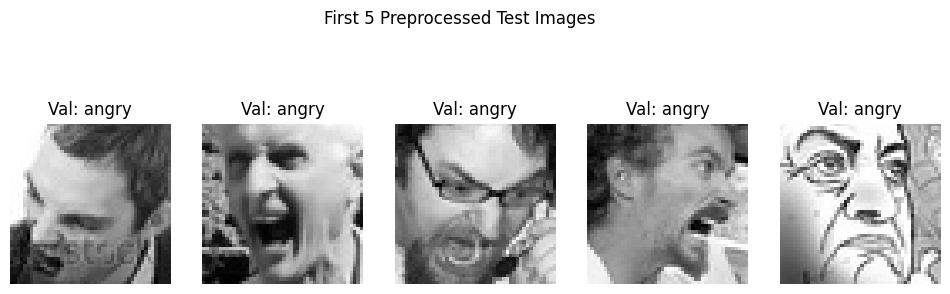

In [39]:
# Show first 5 preprocessed train images
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Train: {emotion_labels[y_train[i]]}")
    plt.axis('off')
plt.suptitle("First 5 Preprocessed Train Images")
plt.show()

# Show first 5 preprocessed validation images
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title(f"Val: {emotion_labels[y_test[i]]}")
    plt.axis('off')
plt.suptitle("First 5 Preprocessed Test Images")
plt.show()

## Check Class Imbalance

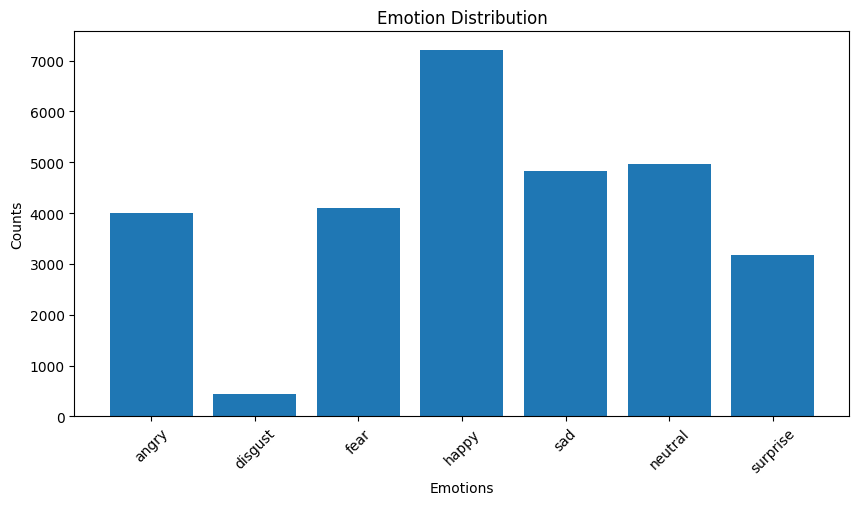

In [40]:
value_counts = np.bincount(y_train)
plt.figure(figsize=(10, 5))
plt.bar(emotion_labels, value_counts)
plt.xlabel("Emotions")
plt.ylabel("Counts")
plt.title("Emotion Distribution")
plt.xticks(rotation=45)
plt.show()

We see here that there's class imbalance, we will have to assign weights to each class

In [41]:
# shuffle the data
shuffle_train_indices = np.random.permutation(len(X_train)-1)

X_train = X_train[shuffle_train_indices]
y_train = y_train[shuffle_train_indices]

shuffle_test_indices = np.random.permutation(len(X_test)-1)

X_test = X_test[shuffle_test_indices]
y_test = y_test[shuffle_test_indices]

print("Shuffled Data Successfully")

Shuffled Data Successfully


# Feature Extraction

In [43]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/12.9 MB 10.5 MB/s eta 0:00:02
   --------------------- ------------------ 6.8/12.9 MB 19.1 MB/s eta 0:00:01
   --------------------------- ------------ 8.9/12.9 MB 16.3 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.9 MB 16.4 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 15.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 11.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
from skimage.feature import hog, local_binary_pattern
from skimage.filters import prewitt, scharr, laplace, gabor
from skimage.restoration import denoise_tv_chambolle
import cv2
import numpy as np

def extract_features_from_image(img):
    # Ensure the image is in 2D grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Normalize image for OpenCV if needed
    if gray.max() <= 1:
        gray = (gray * 255).astype(np.uint8)

    # 1. Sobel Edge Detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edge = np.sqrt(sobelx**2 + sobely**2)

    # 2. Canny Edge Detection
    try:
        canny_edges = cv2.Canny(gray, 100, 200)
    except Exception as e:
        print(f"Error applying Canny edge detection: {e}")
        canny_edges = np.zeros_like(gray)

    # 3. HOG
    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # 4. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')

    # 5. Gaussian Blur
    blurred_img = cv2.GaussianBlur(gray, (5, 5), 0)

    # 6. Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # 7. Scharr
    scharr_edge = scharr(gray)

    # 8. Prewitt
    prewitt_edge = prewitt(gray)

    # 9. Median Filter
    median_filtered = cv2.medianBlur(gray, 5)

    # 10. Gabor Filter
    gabor_response, _ = gabor(gray, frequency=0.6)

    # Return all 2D feature images
    return (
        sobel_edge,
        canny_edges,
        hog_image,
        lbp,
        blurred_img,
        laplacian,
        scharr_edge,
        prewitt_edge,
        median_filtered,
        gabor_response
    )

# Dataset feature extraction (same as before)
def extract_features_for_dataset(X_data):
    all_features = []
    for img in X_data:
        img = img.reshape(48, 48)
        features = extract_features_from_image(img)
        all_features.append(features)
    return np.array(all_features)

### Apply Parallel Processing in Feature Extraction

In [45]:
from joblib import Parallel, delayed

def extract_features_parallel(X_data, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(extract_features_from_image)(img.reshape(IMG_SIZE, IMG_SIZE)) for img in X_data
    )
    return np.array(results)

In [46]:
# Assuming X_train and X_test are your training and test datasets
X_train_feat = extract_features_parallel(X_train)
X_test_feat = extract_features_parallel(X_test)

# Print shapes of the extracted feature sets
print(f"Shape of extracted features for X_train: {X_train_feat.shape}")
print(f"Shape of extracted features for X_test: {X_test_feat.shape}")

Shape of extracted features for X_train: (28708, 10, 48, 48)
Shape of extracted features for X_test: (7177, 10, 48, 48)


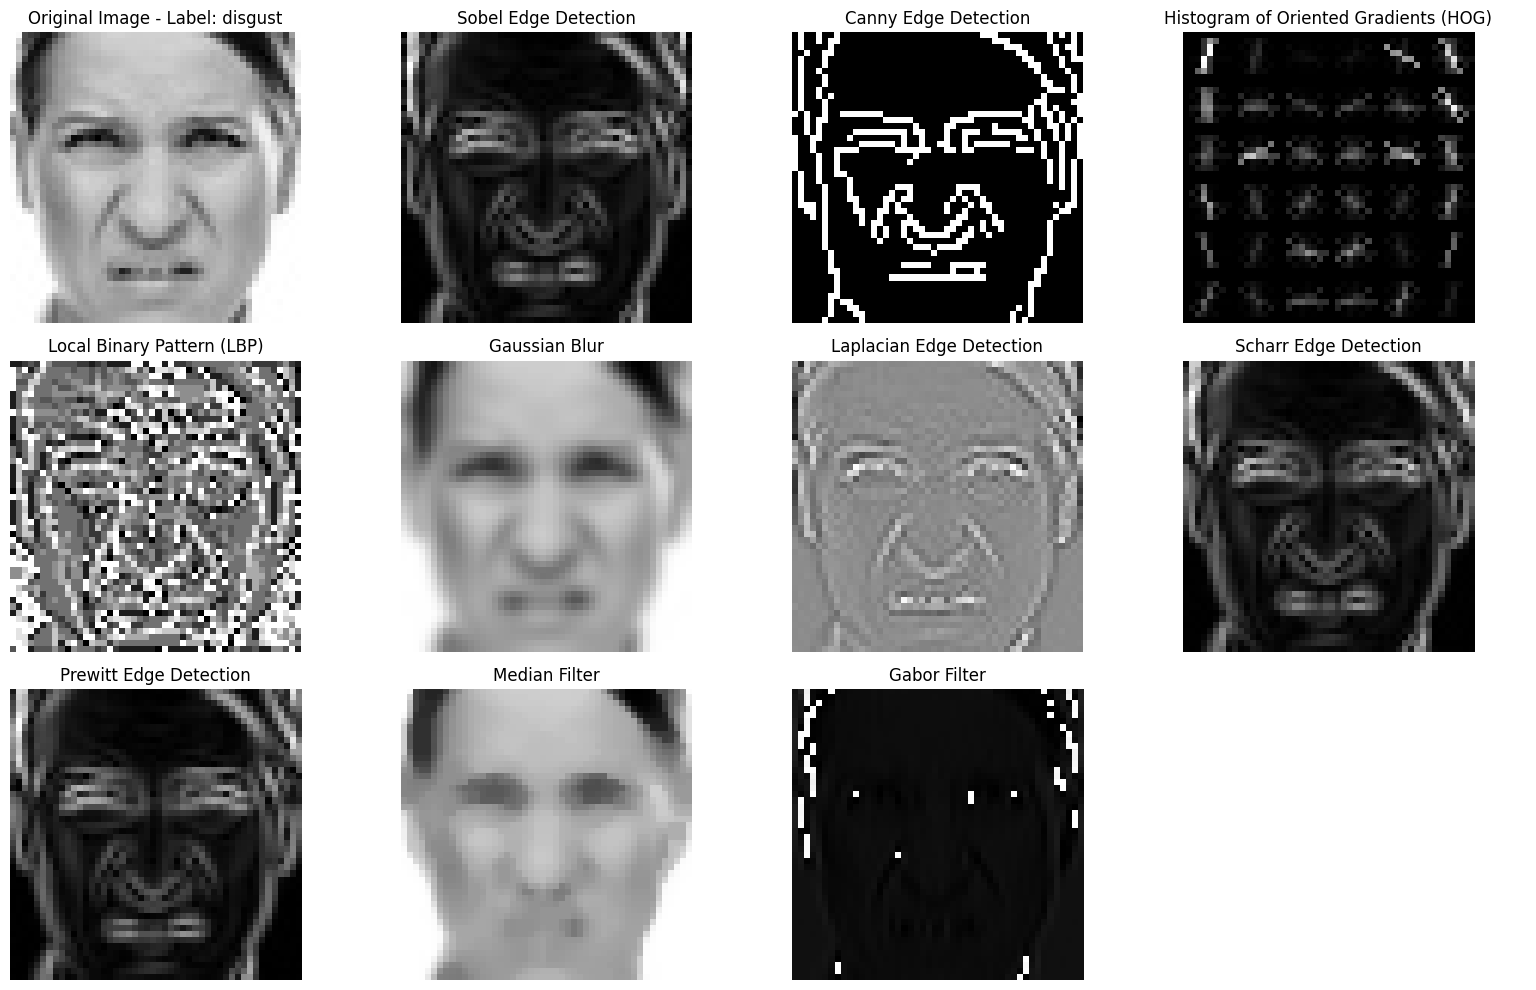

In [47]:
# First image and label
first_image = X_train[0].reshape(48, 48)
first_image_label = emotion_labels[y_train[0]]

# Extract features (this function now returns 10 feature images)
features = extract_features_from_image(first_image)

# Titles for each feature
titles = [
    f"Original Image - Label: {first_image_label}",
    "Sobel Edge Detection",
    "Canny Edge Detection",
    "Histogram of Oriented Gradients (HOG)",
    "Local Binary Pattern (LBP)",
    "Gaussian Blur",
    "Laplacian Edge Detection",
    "Scharr Edge Detection",
    "Prewitt Edge Detection",
    "Median Filter",
    "Gabor Filter"
]

fig, axes = plt.subplots(3, 4, figsize=(16, 10))

# Flatten axes to loop easily
axes = axes.flatten()

# Plot original image first
axes[0].imshow(first_image, cmap='gray')
axes[0].set_title(titles[0])
axes[0].axis('off')

# Plot all feature maps
for i, feature_img in enumerate(features):
    axes[i + 1].imshow(feature_img, cmap='gray')
    axes[i + 1].set_title(titles[i + 1])
    axes[i + 1].axis('off')

# Hide any remaining unused subplots (if less than 12)
for j in range(len(features) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [48]:
# Flatten the extracted feature set
X_train_feat_flattened = X_train_feat.reshape(X_train_feat.shape[0], -1)  # Flatten each sample
X_test_feat_flattened = X_test_feat.reshape(X_test_feat.shape[0], -1)  # Flatten each sample

# Print the new shape to verify
print(f"Shape of flattened features for X_train: {X_train_feat_flattened.shape}")
print(f"Shape of flattened features for X_test: {X_test_feat_flattened.shape}")

Shape of flattened features for X_train: (28708, 23040)
Shape of flattened features for X_test: (7177, 23040)


# Model Construction & Evaluation

## Random Forest

In [49]:
# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)

# Train the model
rf_model.fit(X_train_feat_flattened, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.4min


RandomForestClassifier(random_state=42, verbose=1)

In [50]:
# Predict on the test data
y_pred = rf_model.predict(X_test_feat_flattened)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


Accuracy on test data: 47.23%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.19      0.26       958
           1       1.00      0.28      0.44       111
           2       0.49      0.27      0.35      1024
           3       0.46      0.83      0.60      1774
           4       0.37      0.34      0.36      1247
           5       0.44      0.43      0.44      1233
           6       0.75      0.56      0.64       830

    accuracy                           0.47      7177
   macro avg       0.56      0.42      0.44      7177
weighted avg       0.48      0.47      0.45      7177

Accuracy: 0.4723


## XGBoost

In [52]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/150.0 MB 11.2 MB/s eta 0:00:14
   - -------------------------------------- 7.1/150.0 MB 20.8 MB/s eta 0:00:07
   -- ------------------------------------- 10.0/150.0 MB 22.1 MB/s eta 0:00:07
   --- ------------------------------------ 12.3/150.0 MB 16.4 MB/s eta 0:00:09
   ---- ----------------------------------- 17.3/150.0 MB 17.9 MB/s eta 0:00:08
   ------ --------------------------------- 23.1/150.0 MB 19.5 MB/s eta 0:00:07
   ------- -------------------------------- 27.8/150.0 MB 19.8 MB/s eta 0:00:07
   -------- ------------------------------- 33.0/150.0 MB 20.6 MB/s eta 0:00:06
   ---------- ----------------------------- 38.8/150.0 MB 21.4 MB/s eta 0:00:06
   ----------- ---------------------------- 44.6/150.0 MB 22.0 MB/s eta 0:00:05
   ------------- -------------------------- 49.3/150.


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert data into DMatrix, which is the format XGBoost prefers
dtrain = xgb.DMatrix(X_train_feat_flattened, label=y_train)
dval = xgb.DMatrix(X_test_feat_flattened, label=y_test)

# Set hyperparameters for XGBoost
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(y_train)),
    'max_depth': 6,
    'eta': 0.1,
    'eval_metric': 'merror',
    'tree_method': 'hist',
    'device': 'cuda'
}


# Train the model
num_round = 100  # number of boosting rounds (trees)
bst = xgb.train(params, dtrain, num_round)

# Make predictions on the validation data
y_pred_xgb = bst.predict(dval)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy on test data using XGBoost: {accuracy_xgb * 100:.2f}%")

Accuracy on test data using XGBoost: 51.53%


### Data Augmentation

In [54]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

In [55]:
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights_array))
class_weights

{0: np.float64(1.0265689254425174),
 1: np.float64(9.406290956749672),
 2: np.float64(1.0010111928588863),
 3: np.float64(0.5684189684189684),
 4: np.float64(0.8490979000295771),
 5: np.float64(0.826010645950223),
 6: np.float64(1.2937359170797658)}

## CNN

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization, SpatialDropout2D, Activation
)
from tensorflow.keras.regularizers import l2


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same',),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same',),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu', padding='same',),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(512, (3,3), activation='relu', padding='same',),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),

    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes
])

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,17

 Total params: 2,104,455 (8.03 MB)

 Trainable params: 2,102,471 (8.02 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [58]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)


In [59]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [60]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_train.shape

(22966, 48, 48, 1)

In [61]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val), 
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
)

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 202s 536ms/step - accuracy: 0.1752 - loss: 2.0920 - val_accuracy: 0.0162 - val_loss: 3.1794 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 174s 484ms/step - accuracy: 0.2521 - loss: 1.8564 - val_accuracy: 0.3164 - val_loss: 1.7098 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 175s 488ms/step - accuracy: 0.3102 - loss: 1.7692 - val_accuracy: 0.3090 - val_loss: 1.7724 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 171s 478ms/step - accuracy: 0.3454 - loss: 1.7113 - val_accuracy: 0.2736 - val_loss: 1.9487 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.3762 - loss: 1.6107
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
359/359 ━━━━━━━━━━━━━━━━━━━━ 165s 458ms/step - accuracy: 0.3762 - loss: 1.6107 - val_accuracy: 0.2729 - val_loss: 1.8759 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 166s 462ms/step - accuracy:

In [62]:
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test.shape

(7177, 48, 48, 1)

In [63]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6047 - loss: 1.0642
Test Accuracy: 59.57%


In [64]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step


In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.52      0.50       958
           1       0.25      0.77      0.38       111
           2       0.51      0.27      0.35      1024
           3       0.84      0.80      0.82      1774
           4       0.51      0.45      0.48      1247
           5       0.53      0.61      0.57      1233
           6       0.65      0.83      0.73       830

    accuracy                           0.60      7177
   macro avg       0.54      0.61      0.55      7177
weighted avg       0.60      0.60      0.59      7177



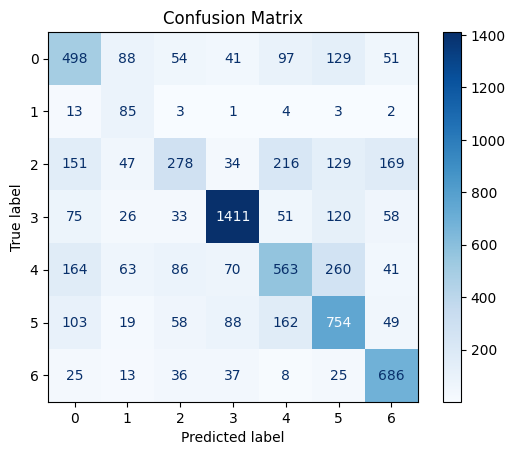

In [66]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

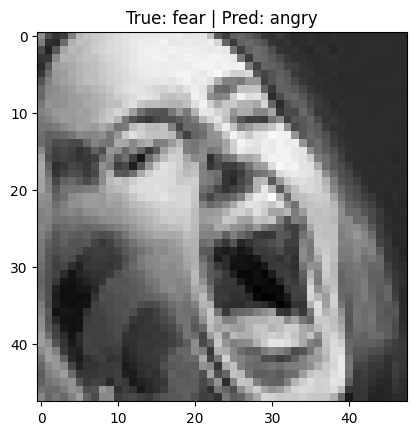

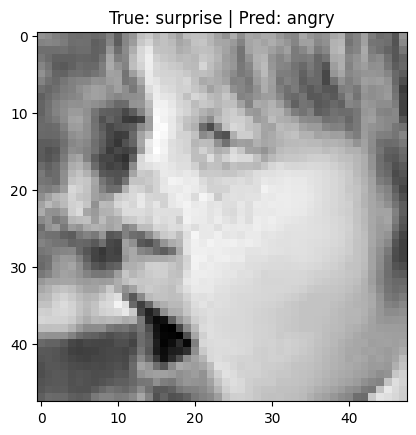

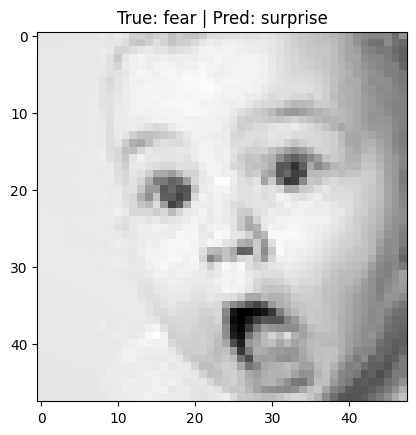

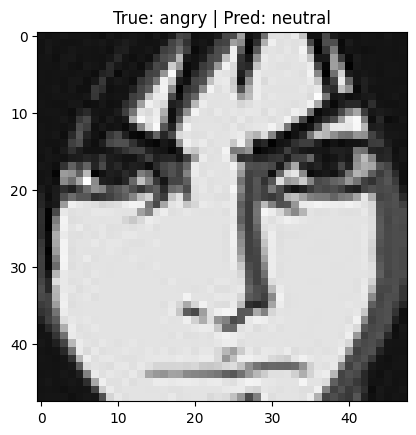

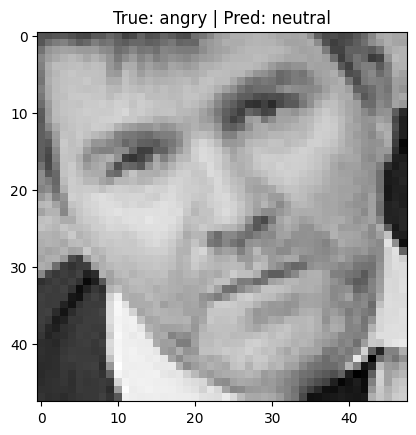

In [67]:
# Visualize some missclassified samples
wrong = np.where(y_pred != y_test)[0]


for i in wrong[:5]:
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"True: {emotion_labels[y_test[i]]} | Pred: {emotion_labels[y_pred[i]]}")
    plt.show()

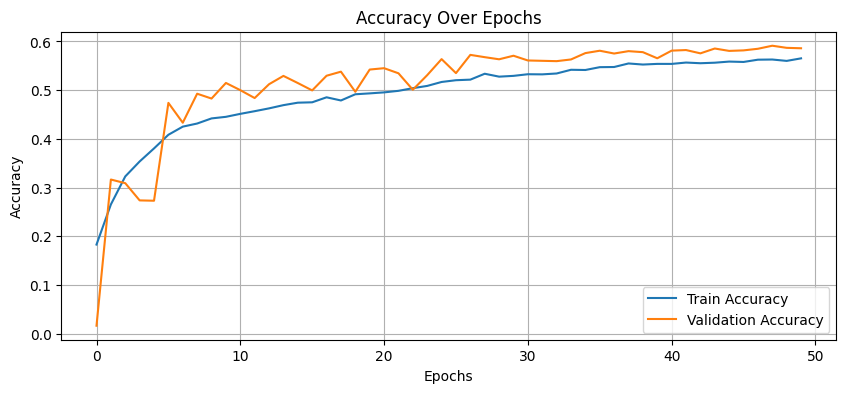

In [68]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

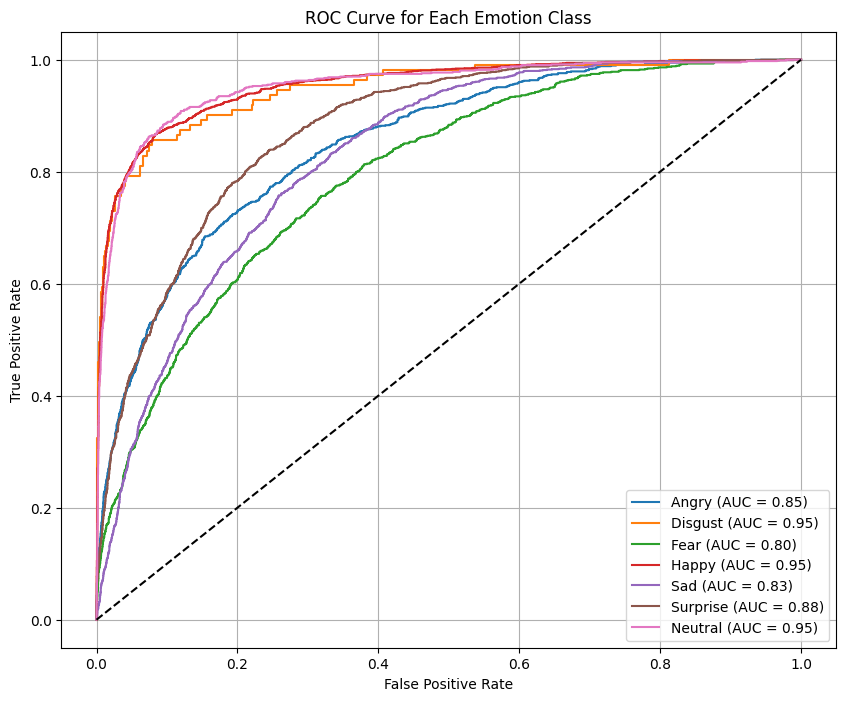

In [69]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Your integer class labels (0 to 6), shape: (num_samples,)
# Example:
# y_true = np.array([0, 2, 1, 4, ...])
# y_pred_probs = model.predict(X_test)  # shape: (num_samples, 7)

# 1. Binarize the y_true just for ROC plotting
y_true_bin = label_binarize(y_test, classes=list(range(7)))  # shape: (num_samples, 7)

# 2. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot ROC curves
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'{emotion_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Emotion Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [70]:
model.save('facial_emotion_model.h5')


